In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
from IPython import display
from math import sin,pi,exp, log


def Rayan(N,cfl,endtime,space_dis,time_dis,initials):
#################################################user defined############################################
# cfl = 0.3
# N = 20
# endtime = 3
# space_dis = 'cd2' # e or cd2
# time_dis = 'euler' #  'cn' or 'rk4' or 'euler'
# initials = 's1'# s1 or s3
#################################################End ofuser defined############################################

#################################################PREPROCCES DEFINITIONS############################################
    h = 2*pi/N
    delt = cfl
    t = np.arange(0,endtime+delt,delt)
    x = np.linspace(0,2*pi-h,N)
    y = np.linspace(0,2*pi-h,N)
    frames = len(t)
    S= np.zeros((frames,N, N)) 
    x, y = np.meshgrid(x, y)

    #################################################END OF PREPROCCES DEFINITIONS############################################

    ######################################Initial shape conditions###################################
    if initials == 's1':
        S[0:,:] = np.sin(x)+np.sin(y)
    elif initials == 's3':
        S[0:,:] = np.sin(x)+np.sin(3*y)

    ######################################End of Initial shape conditions###################################


    #################################################DERIVATIVES############################################
    if space_dis=='cd2' and time_dis=='cn':        
        M = np.zeros([N,N])
        for i in range(N-2):        
            M[i,i+1] = 1
            M[i+1,i] = 1
            M[i,i] = -2
        M[0,N-1] = 1
        M[N-1,N-2] = 1
        M[N-1,0] = 1
        M[N-2,N-1] = 1
        M[N-1,N-1] = -2
        M[N-2,N-2] = -2
        M = (1/(h**2))*M
        YM = np.zeros([N**2,N**2])
        for i in range (N**2):
            YM[i,i] = -2
        for i in range(N**2-N):
            YM[i,i+N] = 1
            YM[i+N,i] = 1
        for i in range(N):
            YM[i,i+N**2-N] = 1
            YM[N**2-1-i,N-i-1] = 1
        YM = (1/(h**2))*YM          
        BIGM = np.zeros([N**2,N**2])
        for i in range(N):
            BIGM[i*N:i*N+N,i*N:i*N+N] = M
        def derivate(N):
            return BIGM, YM

    else:
        M = np.zeros([N,N])
        for i in range(N-2):  
            M[i,i+1] = 1
            M[i+1,i] = 1
            M[i,i] = -2
        M[0,N-1] = 1
        M[N-1,N-2] = 1
        M[N-1,0] = 1
        M[N-2,N-1] = 1
        M[N-1,N-1] = -2
        M[N-2,N-2] = -2
        M = (1/(h**2))*M
        BIGM = np.zeros([N**2,N**2])
        for i in range(N):
            BIGM[i*N:i*N+N,i*N:i*N+N] = M
        def derivate(N,s):           
            ################ DX
            sx = s.flatten()
            dx = BIGM.dot(sx)
            dx = np.reshape(dx, (-1, N))
            ###################DY
            sy = np.transpose(s)
            sy = sy.flatten()
            dy = BIGM.dot(sy)
            dy = np.reshape(dy, (-1, N))
            dy = np.transpose(dy)
            return dx, dy
    #################################################END OF DERIVATIVES############################################





    # for i in range(frames-1):
    #     S[i+1:,:] = S[i,:,:]-delt*(np.sin(S[i,:,:])+np.sin(S[i,:,:]))

    if time_dis == 'euler':
        def solve():      
            for i in range(frames-1):
                S[i+1:,:] = S[i,:,:]+delt*(derivate(N,S[i,:,:])[0]+derivate(N,S[i,:,:])[1])    
            return S
    elif time_dis=='rk4':    
        def solve():
            for i in range(frames-1):
                k1x = derivate(N,S[i,:,:])[0]
                k1y = derivate(N,S[i,:,:])[1]
                u2_1 = S[i,:,:] +0.5*delt*(k1x+k1y)
                k2x = derivate(N,u2_1)[0]
                k2y = derivate(N,u2_1)[1]
                u2_2 = S[i,:,:] +0.5*delt*(k2x+k2y)
                k3x = derivate(N,u2_2)[0]
                k3y = derivate(N,u2_2)[1]
                u3 = S[i,:,:] +delt*(k3x+k3y)
                k4x = derivate(N,u3)[0]
                k4y = derivate(N,u3)[1]
                S[i+1,:,:] = S[i,:,:] + (1/6)*delt*(k1x+k1y +2*k2x+2*k2y+2*k3x+2*k3y+k4x+k4y)
            return S
    elif time_dis=='e': 
        if initials == 's1':
            def solve():
                for i in range(frames-1):
                    S[i+1,:,:] = S[0,:,:]*exp(-t[i+1])
                return S
        elif initials == 's3':
            def solve():
                for i in range(frames-1):
                    S[i+1,:,:] =  np.sin(x)*exp(-t[i+1])+np.sin(3*y)*exp(-t[i+1]*9)
                return S
    elif time_dis=='cn':
        def  solve():
            I =  np.identity(N**2)
            A1 = I-0.5*delt*derivate(N)[0]
            B1 = I+0.5*delt*derivate(N)[1]
            C1 = I-0.5*delt*derivate(N)[1]
            D1 = I+0.5*delt*derivate(N)[0]
            A1 = np.linalg.inv(A1)
            C1 = np.linalg.inv(C1)
            s = S[0,:,:].flatten()
            for i in range(frames-1):
                dummy = B1.dot(s)
                dummy = A1.dot(dummy)
                dummy = D1.dot(dummy)
                s = C1.dot(dummy)
                S[i+1,:,:] = np.reshape(s, (-1, N))
            return S
    
    
    S = solve()
    return S,frames,h



Text(0.5, 1.0, 'CD2,Euler, Space order verification, L1')

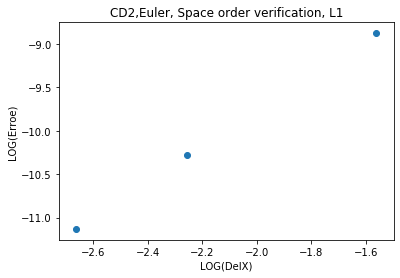

In [3]:
#def Rayan(N,cfl,endtime,space_dis,time_dis,initials):
cfl = 0.00005
N = 15
h = 2*pi/N
delt = cfl*h*h
endtime = 0.05
x = np.linspace(0,2*pi,N)
StepN = round(endtime/delt)
shape = 's1'

e,ne,dtdum = Rayan(30,cfl,endtime,'cd2','e',shape)
e2,ne2,dtdum = Rayan(60,cfl,endtime,'cd2','e',shape)
e3,ne3,dtdum = Rayan(90,cfl,endtime,'cd2','e',shape)
euler,neuler,dt = Rayan(30,cfl,endtime,'cd2','euler',shape)
euler1,neuler1,dt1 = Rayan(60,cfl,endtime,'cd2','euler',shape)
euler2,neuler2,dt2 = Rayan(90,cfl,endtime,'cd2','euler',shape)
E = np.average(np.absolute(e[ne-1,:,:].flatten()-euler[neuler-1,:,:].flatten()))
E1 = np.average(np.absolute(e2[ne2-1,:,:].flatten()-euler1[neuler1-1,:,:].flatten()))
E2 = np.average(np.absolute(e3[ne3-1,:,:].flatten()-euler2[neuler2-1,:,:].flatten()))

plt.scatter([log(dt),log(dt1),log(dt2)],[log(E),log(E1),log(E2)])
plt.ylabel('LOG(Erroe)')
plt.xlabel('LOG(DelX)')
plt.title('CD2,Euler, Space order verification, L1')

Text(0.5, 1.0, 'CD2,Euler, Space order verification, Linfi')

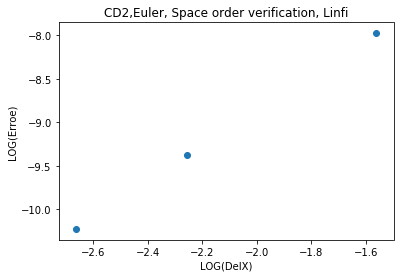

In [4]:
#def Rayan(N,cfl,endtime,space_dis,time_dis,initials):
cfl = 0.00005
N = 15
h = 2*pi/N
delt = cfl*h*h
endtime = 0.05
x = np.linspace(0,2*pi,N)
StepN = round(endtime/delt)
shape = 's1'

e,ne,dtdum = Rayan(30,cfl,endtime,'cd2','e',shape)
e2,ne2,dtdum = Rayan(60,cfl,endtime,'cd2','e',shape)
e3,ne3,dtdum = Rayan(90,cfl,endtime,'cd2','e',shape)
euler,neuler,dt = Rayan(30,cfl,endtime,'cd2','euler',shape)
euler1,neuler1,dt1 = Rayan(60,cfl,endtime,'cd2','euler',shape)
euler2,neuler2,dt2 = Rayan(90,cfl,endtime,'cd2','euler',shape)
E = (np.absolute(e[ne-1,:,:].flatten()-euler[neuler-1,:,:].flatten())).max()
E1 = (np.absolute(e2[ne2-1,:,:].flatten()-euler1[neuler1-1,:,:].flatten())).max()
E2 = (np.absolute(e3[ne3-1,:,:].flatten()-euler2[neuler2-1,:,:].flatten())).max()

plt.scatter([log(dt),log(dt1),log(dt2)],[log(E),log(E1),log(E2)])
plt.ylabel('LOG(Erroe)')
plt.xlabel('LOG(DelX)')
plt.title('CD2,Euler, Space order verification, Linfi')